# More examples of model fitting (and how to do it poorly).

### Goals:

1. To understand how spectral data is used to estimate the doppler shift (and speed) of distant galaxies.
2. To be amazed that galaxies can be moving so quickly.
3. To trying fitting spectral data from the Sloan Digital Sky Survey (SDSS).
4. To understand some of the pitfalls in fitting data.

### Timing

1. Try to finish this notebook in 30-35 minutes. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

# Sloan Digital Sky Survey

The Sloan Digital Sky Survey ([Project page](https://www.sdss.org/), [Wikipedia](https://en.wikipedia.org/wiki/Sloan_Digital_Sky_Survey)) truly changed the way we understand the universe.  

Over the course of 20 years, SDSS observed 35% of the sky and catalogued about 1 billion stars and galaxies.

It addition to taking images of such a large part of the sky, SDSS also measures the spectrum of the light from over 4 million objects.  

The spectra are obtained by feeding an individual optical fiber for each target through a hole drilled in an aluminum plate.  The light from the fiber is then passed into a diffraction grating to seperate out the different wavelength so that the spectrum for that target can be measured.   The diffracted light was then directed to an array of sensors, so that each sensor measured the amount of light at a different wavelength.

Each hole is positioned specifically for a selected target, so every field in which spectra are to be acquired requires a unique plate.  In spectroscopic mode, the telescope tracks the sky in the standard way, keeping the objects focused on their corresponding fiber tips. 

Here is a picture of one such aluminum plate:

![SDSS plug plate](figures/plate-sdss.jpg)

We are going to be looking at the data from one fiber for one plate.  

By comparing the wavelength of atomic emission lines observed from our target to the known wavelengths of those lines we can measure the doppler shift of the light from that target.

In [3]:
data = np.loadtxt(open("../data/sds_galaxy.txt", 'rb'), usecols=range(4))

# This is how we pull out the data from columns in the array.

# They put the data in Angstroms, lets use nano-meters instead, 1 Angstrom = 0.1 nm. 
wavelength = data[:,0] / 10.
flux = data[:,1]
best_fit = data[:,2]
sky_flux = data[:,3]

FWIW, the "flux" is actually the amount of energy arriving in a narrow wavelength band, per area, per time, and is given in units of $\frac{{\rm erg}}{{\rm cm}^{2}s^{1}{{\rm angstrom}}^{1}}$.  

Rather than write that out again and again, let's call those "arcane units".

In short you can think of it as the amount of energy coming in from light of a given wavelength.

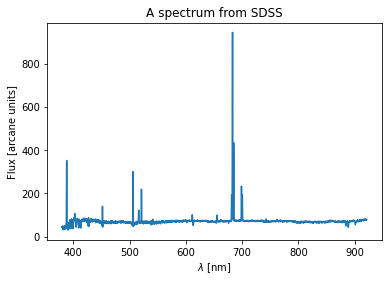

In [4]:
plt.plot(wavelength, best_fit)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.title("A spectrum from SDSS")
plt.show()

### $H\alpha$ line

The brightest line is this spectrum is the Hydrogen $\alpha$ line, which is typically the brightest line in the optical range. [Wikipedia page on H$\alpha$](https://en.wikipedia.org/wiki/H-alpha)

Let's do a quick estimate of the wavelength of the H $\alpha$ line from this object, the redshift of the object, and the implied velocity.  

In [5]:
# Which item in the array has the largest value
peak_idx = np.argmax(flux)
# What is the corresponding wavelength
peak_wl = wavelength[peak_idx]
print(f"The peak wavelength is {peak_wl:0.2f} nm")
H_alpha = 656.4614
print(f"In a vacuum, the H alpha line is at {H_alpha:.4f} nm")
z1 = (peak_wl/H_alpha)-1
print(f"This corresponds to a redshift of {z1:.5f}")
r2 = (peak_wl/H_alpha)**2
beta = (1 - (1/r2))/(1 + (1/r2))
print(f"Based on this line we estimate that this object is moving away from us with a velocity of {beta:0.4f} c")

The peak wavelength is 682.97 nm
In a vacuum, the H alpha line is at 656.4614 nm
This corresponds to a redshift of 0.04038
Based on this line we estimate that this object is moving away from us with a velocity of 0.0396 c


### Question for dicussion

#### 4.1 About far away is this object?  You can estimate it based on Hubble's law $v = H_0 d$.

You can use the Hubble parameter is about $H_0 = 70 \frac{{\rm km}}{{\rm s}}{\rm Mpc}^{-1}$.

The speed of light is about $c = 3 \times 10^8 m/s$.

$1 {\rm pc} = 3.26 {\rm ly}$.

Note that this computation leaves out some subtleties, like what we mean by "how far away", as in "how far away when the light was emitted?" or "how far away right now?", and that isn't even getting into the issues that come up when we consider relativity or the acceleration of the Universe.

But anyway, at least it gives you a distance scale to think about.

If you are curious the details, have a look at this:

[Ned Wright's Cosmological Distance Calculator](http://www.astro.ucla.edu/~wright/CosmoCalc.html)

#### Note.  The unit conversions here are actually pretty involved.  If you are short on time you might want to move on and do the math when you are writing up the report.

### Zoom in on $H \alpha$ line.

If we zoom in on the line, we see it is actually three lines.   That complicates things for trying to fit the lines to a model, as we would have to include all three lines in our model.  

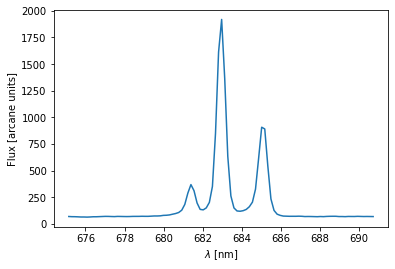

In [6]:
cutout_wl = wavelength[peak_idx-50:peak_idx+50]
cutout_flux = flux[peak_idx-50:peak_idx+50]
plt.plot(cutout_wl, cutout_flux)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.show()

Let's skip trying to fit this and focus on a simpler case.

### The $H \beta$ line.

The brightest line just around 500 nm is the $H \beta$ line, the little sibling of the $H \alpha$ line.  It is more isolated, making it a better choice for us to fit with a simple model.


In [7]:
mask = (wavelength > 500) & (wavelength < 510)
cutout_wl = wavelength[mask]
cutout_flux = flux[mask]

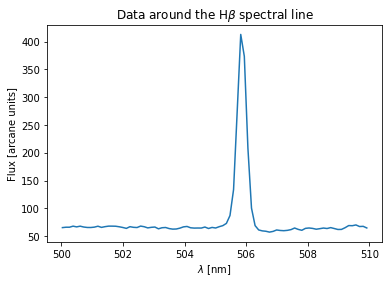

In [8]:
plt.plot(cutout_wl, cutout_flux)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.title(r"Data around the H$\beta$ spectral line")
plt.show()

# Our model

We are going to fit this line to a model with two parts.

   1. We will model this line itself as a Gaussian $ G(\lambda | \mu, \sigma)$ times a prefactor that give the height of the peak ($n$).  
   2. We will model the background as a slope and offset.  To reduce the correlation between the two, we will define the offset at 500 nm.   $p_0 + (\lambda - 500)*p_1$.
   
This gives us a model with five parameters. $(n, \mu, \sigma, p_0, p_1)$.

$m(\lambda | n, \mu, \sigma, p_0, p_1) = n G(\lambda | \mu, \sigma) + p_0 + (\lambda - 500)*p_1$.

This next cell codes up the model and the functions we need for the fitting.

This is just a slightly more complicated version of what we did in the first notebook.  The added complication is just coming in because the model has a few more parameters.

In [9]:
from functools import partial

def Gauss(x, prefact, mu, sigma):
    return prefact*stats.norm(loc=mu, scale=sigma).pdf(x)

def poly1(x, offset, slope):
    return offset + (x-500)*slope

def model_func(x, prefact, mu, sigma, offset, slope):
    return Gauss(x, prefact, mu, sigma) + poly1(x, offset, slope)

def generic_chi2(params, data_vals, model, x):
    model_vals = model(x, *params)
    return np.sum((data_vals - model_vals)**2)

def cost_func(data_vals, model, x):
    return partial(generic_chi2, data_vals=data_vals, model=model, x=x)

### Initial guess

Let's guess some initial values for the parameters and plot the model to see how it looks.

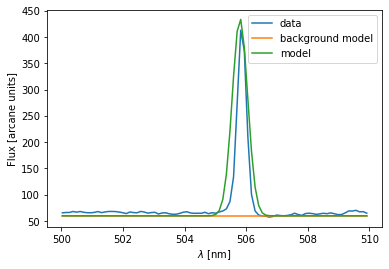

In [11]:
prefact_0 = 235.
mu_0 = 505.8
sigma_0 = 0.25
offset_0 = 60
slope_0 = 0

init_pars = (prefact_0, mu_0, sigma_0, offset_0, slope_0)
model_vals = model_func(cutout_wl, *init_pars)
background_vals = poly1(cutout_wl, init_pars[3], init_pars[4])

plt.plot(cutout_wl, cutout_flux, label="data")
plt.plot(cutout_wl, background_vals, label="background model")
plt.plot(cutout_wl, model_vals, label="model")
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel(r'Flux [arcane units]')
plt.legend()
plt.show()

# Getting the cost function

First we are going to fit using a cost function that uses the full model to compare to the data.  

Pro-tip for programmers, we are calling a function that returns another function.  It's pretty meta.
The reason we need to do this is that the minimizer expects a function that only takes the
model paramters, but in general our cost_function depends on some other things as well.

So we write a function that wraps around the generic cost function to give us a specific verison of it.

If you found that explanation confusing, don't worry about it.  The point is just that `our_cost_func` is a version of the cost function that works with the data we have and the model we described above.

In [12]:
our_cost_func = cost_func(cutout_flux, model_func, cutout_wl)
our_cost_func(init_pars)

95492.91291788916

### Fitting the model

Let's go ahead and fit the model and print out the results.

In [13]:
result = optimize.minimize(our_cost_func, x0=np.array(init_pars))
fit_pars = result['x']
model_fit = model_func(cutout_wl, *fit_pars)
background_fit = poly1(cutout_wl, fit_pars[3], fit_pars[4])
print("Best Fit ---------")
print(f"Line Intensity: {fit_pars[0]:.1f} [arcane units]")
print(f"Line Peak: {fit_pars[1]:.4f} [nm]")
print(f"Line Width: {fit_pars[2]:.4f} [nm]")
print(f"Background at 500 nm: {fit_pars[3]:.2f} [arcane units]")
print(f"Background slope: {fit_pars[4]:.2f} [arcane_units / nm]")

Best Fit ---------
Line Intensity: 132.0 [arcane units]
Line Peak: 505.8599 [nm]
Line Width: 0.1474 [nm]
Background at 500 nm: 66.80 [arcane units]
Background slope: -0.31 [arcane_units / nm]


### Plotting the fit results

Let's make a plot of the data and the model, and let's break out the background part of the model.

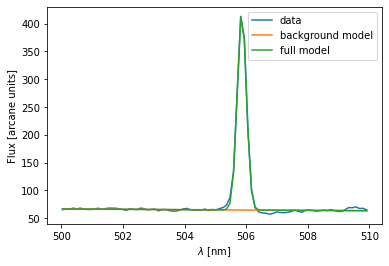

In [14]:
plt.plot(cutout_wl, cutout_flux, label="data")
plt.plot(cutout_wl, background_fit, label="background model")
plt.plot(cutout_wl, model_fit, label="full model")
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.legend()
plt.show()

### Questions for discussion

#### 5.1 Before going further, it is important to make sure you understand the previous plot and what we did to make it.  So, describe the plot and how we made it, and what it means.  What is the difference between this plot and the plot we made for the initial guess of the model parameters? 

In [15]:
H_beta = 486.2721

z2 = (fit_pars[1]/H_beta)-1
print(f"We fit the peak of the line at {fit_pars[1]:.4f} nm")
print(f"In a vacuum, the H beta line is at {H_beta:.4f} nm")
print(f"This corresponds to a redshift of {z2:.5f}")
r2 = (fit_pars[1]/H_beta)**2
beta = (1 - (1/r2))/(1 + (1/r2))
print(f"Based on this line we estimate that this object is moving away from us with a velocity of {beta:.4f} c")

We fit the peak of the line at 505.8599 nm
In a vacuum, the H beta line is at 486.2721 nm
This corresponds to a redshift of 0.04028
Based on this line we estimate that this object is moving away from us with a velocity of 0.0395 c


### How to do a bad fit, version 1, using a bad model.

In this case we are going to forget to include background model.   To do that we are going to construct the cost function using just the Gaussian instead of the full model.

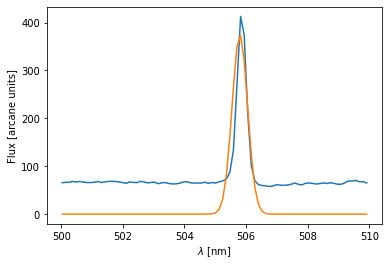

In [16]:
bad_cost_func = cost_func(cutout_flux, Gauss, cutout_wl)

init_pars_bad = (prefact_0, mu_0, sigma_0)
model_fit_bad = Gauss(cutout_wl, *init_pars_bad)
plt.plot(cutout_wl, cutout_flux)
plt.plot(cutout_wl, model_fit_bad)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.show()

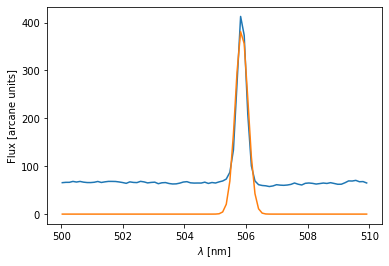

Best Fit ---------
Line Intensity: 199.5 [arcane units]
Line Peak: 505.8582 [nm]
Line Width: 0.2062 [nm]


In [17]:
result_bad = optimize.minimize(bad_cost_func, x0=np.array(init_pars_bad))
fit_pars_bad_1 = result_bad['x']
model_fit_bad = Gauss(cutout_wl, *fit_pars_bad_1)
plt.plot(cutout_wl, cutout_flux)
plt.plot(cutout_wl, model_fit_bad)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.show()

print("Best Fit ---------")
print(f"Line Intensity: {fit_pars_bad_1[0]:.1f} [arcane units]")
print(f"Line Peak: {fit_pars_bad_1[1]:.4f} [nm]")
print(f"Line Width: {fit_pars_bad_1[2]:.4f} [nm]")

### Questions for discussion

#### 6.1 How would you interpret the fit result?  Do the parameters make sense?  What might have happened?  Don't worry if you aren't sure; just guess.

### How to do a bad fit, version 2, using bad initial parameters.

In this case we are going to pick bad values for our initial guess.


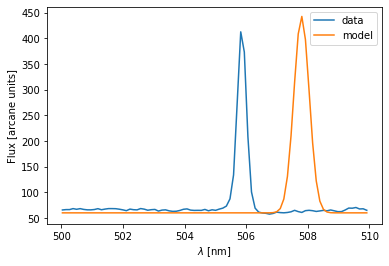

In [18]:
prefact_0 = 240.
mu_0 = 505.8
sigma_0 = 0.25
offset_0 = 60
slope_0 = 0

init_pars_bad_2 = (prefact_0, mu_0+2.0, sigma_0, offset_0, slope_0)
model_fit_bad = model_func(cutout_wl, *init_pars_bad_2)

plt.plot(cutout_wl, cutout_flux, label='data')
plt.plot(cutout_wl, model_fit_bad, label='model')
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.legend()
plt.show()

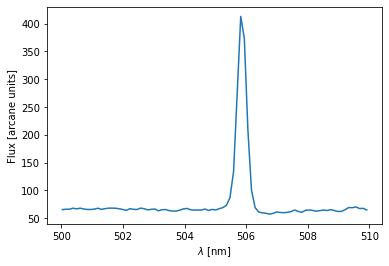

Best Fit ---------
Line Intensity: 9356.3 [arcane units]
Line Peak: 586.6126 [nm]
Line Width: -1228.2635 [nm]
Background at 500 nm: 58441.95 [arcane units]
Background slope: -12853.91 [arcane_units / nm]


In [19]:
result_bad_2 = optimize.minimize(our_cost_func, x0=np.array(init_pars_bad_2))
fit_pars_bad_2 = result_bad_2['x']
model_fit_bad_2 = model_func(cutout_wl, *fit_pars_bad_2)

plt.plot(cutout_wl, cutout_flux)
plt.plot(cutout_wl, model_fit_bad_2)
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel("Flux [arcane units]")
plt.show()

print("Best Fit ---------")
print(f"Line Intensity: {fit_pars_bad_2[0]:.1f} [arcane units]")
print(f"Line Peak: {fit_pars_bad_2[1]:.4f} [nm]")
print(f"Line Width: {fit_pars_bad_2[2]:.4f} [nm]")
print(f"Background at 500 nm: {fit_pars_bad_2[3]:.2f} [arcane units]")
print(f"Background slope: {fit_pars_bad_2[4]:.2f} [arcane_units / nm]")

### Questions for discussion

#### 7.1 What happened?  How would you interpret the fit result?  Do the parameters make sense?

#### 7.2 Try to guess about why we got this result.  What might have happened?  Don't worry if you aren't sure.  Just guess.

#### 7.3 This illustrates that it is often important to start with a reasonable initial guess.  If we were fitting millions of spectra, we would want the program to make the initial guess instead of having to do it by hand.   How might you make an initial guess for the a) Line Peak, b) the Line Width, c) the Background at 500 nm, d) the Background slope?
